# Image classification via fine-tuning with EfficientNet

**Author:** [Yixing Fu](https://github.com/yixingfu)<br>
**Date created:** 2020/06/30<br>
**Last modified:** 2020/07/16<br>
**Description:** Use EfficientNet with weights pre-trained on imagenet for Stanford Dogs classification.

# Experiment with Bilinear CNN
Bilinear CNN paper: http://vis-www.cs.umass.edu/bcnn/
With code from: https://github.com/NiFangBaAGe/FBCNN/blob/master/load_model.py

Self-connected Bilinear like Breast Cancer paper
https://www.frontiersin.org/articles/10.3389/fgene.2020.547327/full

Use Stanford Dogs. A subset of ImageNet-1k chosen for the task of fine-grained image categorization AKA texture AKA fluffiness.
https://www.tensorflow.org/datasets/catalog/stanford_dogs

Rotate the EfficientNet output vectors with PCA to create "meatier" feature vectors.

SHOULD THIS HAVE A SEPARATE PCA ROTATION FOR EVERY CONVOLUTION? 1280 CONVOLUTIONS, 1280 PCA SESSIONS? 

In [1]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224

In [2]:
import gc
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from sklearn.decomposition import IncrementalPCA as PCA
import matplotlib.pyplot as plt

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

gc.collect()

Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


0

In [3]:
import tensorflow_datasets as tfds

batch_size = 256

dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes


When the dataset include images with various size, we need to resize them into a
shared size. The Stanford Dogs dataset includes only images at least 200x200
pixels in size. Here we resize the images to the input size needed for EfficientNet.

In [4]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

### Visualizing the data

The following code shows the first 9 images with their labels.

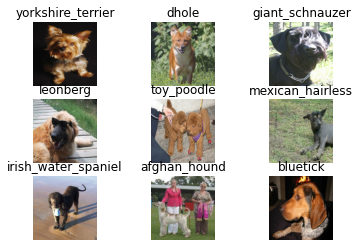

In [5]:
import matplotlib.pyplot as plt


def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")


### Data augmentation

We can use the preprocessing layers APIs for image augmentation.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

This `Sequential` model object can be used both as a part of
the model we later build, and as a function to preprocess
data before feeding into the model. Using them as function makes
it easy to visualize the augmented images. Here we plot 9 examples
of augmentation result of a given figure.

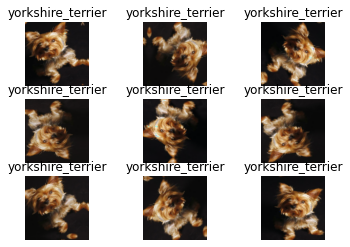

In [7]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")


### Prepare inputs

Once we verify the input data and augmentation are working correctly,
we prepare dataset for training. The input data are resized to uniform
`IMG_SIZE`. The labels are put into one-hot
(a.k.a. categorical) encoding. The dataset is batched.

Note: `prefetch` and `AUTOTUNE` may in some situation improve
performance, but depends on environment and the specific dataset used.
See this [guide](https://www.tensorflow.org/guide/data_performance)
for more information on data pipeline performance.

In [8]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)


A little code for plotting the results.

In [9]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


# plot_hist(hist)

# PCA Rotation Matrix
Create a PCA projection matrix from EfficientNetB0 vectors based on training dataset.

First, create a model that takes Stanford Dog training or test sets and projects them to the end of CNN pipeline, before the final classification top.

In [10]:
NUM_MAPS = 1280
MAP_SIZE = 7 * 7

def build_bare_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    eff = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")
    # Freeze the pretrained weights
    eff.trainable = False
    sub_model = tf.keras.Model(inputs, eff.output, name='effb0')
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = sub_model(inputs)
    x = layers.Reshape((MAP_SIZE, NUM_MAPS))(x)
    x = layers.Permute((2,1))(x)
    print(x.shape)

    # Compile
    model = tf.keras.Model(inputs, x, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model
# with strategy.scope():
bare_model = build_bare_model()
bare_model.summary()
pred1 = bare_model.predict(np.zeros((1, 224, 224, 3)))
print(pred1.shape)

(None, 1280, 49)
Model: "EfficientNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 effb0 (Functional)          (None, 7, 7, 1280)        4049571   
                                                                 
 reshape (Reshape)           (None, 49, 1280)          0         
                                                                 
 permute (Permute)           (None, 1280, 49)          0         
                                                                 
Total params: 4,049,571
Trainable params: 0
Non-trainable params: 4,049,571
_________________________________________________________________
(1, 1280, 49)


In [11]:
def plot_progress(deltas):
    x = np.array(range(len(deltas)), dtype='int32')
    y = np.asarray(deltas)
    #create basic scatterplot
    plt.plot(x, y, 'o')

    #obtain m (slope) and b(intercept) of linear regression line
    m, b = np.polyfit(x, y, 1)

    #add linear regression line to scatterplot 
    plt.plot(x, m*x+b)

    # flush
    plt.show()

In [12]:
sample = None
prev_full = None
deltas = []
pca_set = []
for p in range(NUM_MAPS):
    pca_set.append(PCA(n_components=MAP_SIZE))

def run_pca(ds):
    global sample, prev_full, deltas, pca_set
    gc.collect()
    num_images = 0
    for (images, labels) in ds:
        gc.collect()
        # print(images.shape)
        pred = bare_model.predict(images)
        # print('raw pred shape', pred.shape)
        transp = pred.transpose((1,0,2))
        # print('transposed pred shape', transp.shape)
        if sample is None:
            sample = pred[0]
            print('sample:', sample.shape)
        for i in range(NUM_MAPS):
            maps = transp[i]
            # print('maps', maps.shape)
            pca_set[i].partial_fit(maps)
        # print('components[0]', pca_set[0].components_.shape)

        # Measure deltas of one projected sample across successive training rounds
        # Project every feature map in the sample
        # Save the mean Manhattan distance of all projected feature maps v.s. the previous set of feature maps 
        full = np.zeros((NUM_MAPS, MAP_SIZE))
        for i in range(NUM_MAPS):
            x = pca_set[i].transform(sample[i].reshape((-1, MAP_SIZE)))
            # if i == 0:
            #     print('x', x.shape)
            full[i, :] = x[:]
        if prev_full is not None:
            delta = np.mean(np.abs(prev_full - full))
            print('mean delta:', delta)
            deltas.append(delta)
        prev_full = full
        pred = None
        num_images = num_images + images.shape[0]
    print('num_images', num_images)


We're going to train the IncrementalPCA object to project embedding vectors to a new basis where the information is pushed toward one end of the vector. We will do several round of training using the entire training dataset. Each round uses a shuffled version of the dataset, which should assist with getting to a final PCA projection.

We will plot the mean delta across each sample during the training of IncrementalPCA. This shows that as the PCA is fine-tuned, the projection of the original sample jumps around less and less.

In [13]:
ident = np.eye(MAP_SIZE)
pca_list = [ident for x in range(NUM_MAPS)]

In [14]:
NUM_BATCHES = 1
for x in range(NUM_BATCHES):
    print('PCA batch %d' % x)
    run_pca(ds_train)
    plot_progress(deltas)
if NUM_BATCHES > 0:
    print('matrix.shape:', pca_set[0].components_.shape)
    print('total samples:', pca_set[0].n_samples_seen_)
    pca_list = [pca_set[x].components_ for x in range(len(pca_set))]
    print(len(pca_list))
    print(pca_list[0].shape)

Now that we have a fully trained PCA object, let's plot the classic display of what PCA is all about. PCA projects an N-dimensional space such that the members of the 0-th cell of the output vector has the highest standard deviation, the 1-th cell the second highest stdev, etc.

In [15]:
for (images, labels) in ds_train:
    pred = bare_model.predict(images)
    break
print(pred.shape)
projected = pca_set[0].transform(pred[0])
pred = None
transp = np.transpose(projected)
print(transp.shape)
std = np.ndarray.std(transp, axis=-1)
print(std.shape)
x = np.array(range(std.shape[0]), dtype='int32')
y = np.asarray(std)
#create basic scatterplot
plt.plot(x, y, 'o')

(256, 1280, 49)


NotFittedError: ignored

What this means for our purposes is that we have "concentrated" the variation between embeddings into a smaller set of numbers.

# Bilinear CNN
This layer creates a matrix where the columns are the channel values for all feature maps, and the rows are height X width of the feature maps. It then creates the 'outer product' of the matrix multiplied against itself.

In [16]:
!pip install -q -U git+https://github.com/LanceNorskog/keras-fbcnn.git
from keras_fbcnn import BilinearCNN1D

## Trained embeddings from pre-trained weights

---



Here we initialize the model with pre-trained ImageNet weights,
and we fine-tune it on our own dataset. We do three different trainings:


1.   Train a standard Global-Average-Pooling top
2.   Train a simple top using a Bilinear layer
3.   Train a simple top using PCA to project the EfficientNetB0 embeddings to a more "concentrated" vector space
4.   Create N PCA projectors, one per feature map
5.   Load these into a custom projector layer




In [17]:
""" Given a set of PCA matrices, project a set of input embeddings via each matrix """
class Projector1D(tf.keras.layers.Layer):
    def __init__(self, pca_list, **kwargs):
        self.pca_list = pca_list
        super(Projector1D, self).__init__(**kwargs)

    def build(self, input_shape):
        print('build')
        n_projections = input_shape[-2]
        fmap_size = input_shape[-1]
        self.projectors = tf.Variable(self.pca_list, dtype='float32')
        print('projectors', self.projectors)

    def call(self, inputs):
            
        print('call')
        shape = inputs.shape.as_list()
        print('shape:', shape)
        num_fmaps = shape[1]
        fmap_size = shape[2]
        print('num_fmaps:', num_fmaps)
        print('fmap_size:', fmap_size)
        output_shape = tf.TensorSpec((None, num_fmaps, fmap_size))
        print('output_shape', output_shape)

        def project(t):
            uns = tf.unstack(t)
            print('uns[0].shape', uns[0].shape)
            out = []
            for x in range(num_fmaps):
                out.append(tf.linalg.matvec(self.projectors[x][:,:], uns[0]))
            print('out len', len(out))
            print('out[0].shape', out[0].shape)
            return tf.stack(out)
 

        projected = tf.map_fn(project, elems=inputs)
        print('projected:', projected)
        return projected
  

In [18]:
""" Given a set of PCA matrices, project a set of input embeddings via each matrix """
class Projector1D(tf.keras.layers.Layer):
    def __init__(self, pca_list, **kwargs):
        self.pca_list = pca_list
        super(Projector1D, self).__init__(**kwargs)

    def build(self, input_shape):
        print('build')
        n_projections = input_shape[-2]
        fmap_size = input_shape[-1]
        self.projectors = tf.Variable(self.pca_list, dtype='float32')
        print('projectors', self.projectors)

    def call(self, inputs):
            
        print('call')
        shape = inputs.shape.as_list()
        print('shape:', shape)
        num_fmaps = shape[1]
        fmap_size = shape[2]
        print('num_fmaps:', num_fmaps)
        print('fmap_size:', fmap_size)
        output_shape = tf.TensorSpec((None, num_fmaps, fmap_size))
        print('output_shape', output_shape)

        # def project(t):
        #     uns = tf.unstack(t)
        #     print('uns[0].shape', uns[0].shape)
        #     out = []
        #     for x in range(num_fmaps):
        #         out.append(tf.linalg.matvec(self.projectors[x][:,:], uns[0]))
        #     print('out len', len(out))
        #     print('out[0].shape', out[0].shape)
        #     return tf.stack(out)
 
        projectors_t = tf.stack([self.projectors for x in range(batch_size)])
        print('projectors_t', projectors_t.shape)
        projected = tf.linalg.matvec(projectors_t, inputs, name='projector')

        # projected = tf.map_fn(project, elems=inputs)
        print('projected:', projected)
        return projected
  

In [22]:

def build_model(num_classes, bilinear=False, pca_list=None):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    eff = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")
    # Freeze the pretrained weights
    eff.trainable = False
    sub_model = tf.keras.Model(inputs, eff.output, name='effb0')
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = sub_model(inputs)

    # Build either bilinear or classic global-average-pooling top
    if bilinear and pca_list is not None:
        print('pca_list[0].shape', pca_list[0].shape)
        x_shape = x.shape
        print(x_shape)
        x = layers.Flatten()(x)
        x = layers.Reshape((NUM_MAPS, MAP_SIZE))(x)
        projector = Projector1D(pca_list)
        x = projector(x)
        print('projected.shape', x.shape)
        projector.trainable = False
        x = layers.Permute((2, 1))(x)
        x = BilinearCNN1D()([x, x])
    elif bilinear:
        x = layers.Reshape((NUM_MAPS, MAP_SIZE))(x) 
        x = layers.Permute((2, 1))(x)
        print('reshaped', x)       
        x = BilinearCNN1D()([x, x])
    else:
        x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
        x = layers.BatchNormalization()(x)
        top_dropout_rate = 0.2
        x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    # before model.compile(), input size to pca_dense is not known
    # if pca_list is not None:
    #     dense_weights = pca_dense.get_weights()
    #     print(dense_weights[0].shape)
    #     print(pca_matrix.shape)
    #     assert dense_weights[0].shape == pca_matrix.shape
    #     dense_weights[0] = pca_matrix
    #     pca_dense.set_weights(dense_weights)
    #     pca_dense.trainable = False
    return model

junk = build_model(NUM_CLASSES, bilinear=True)
junk.summary()
junk = build_model(NUM_CLASSES, bilinear=True, pca_list=pca_list)
junk.summary()


reshaped KerasTensor(type_spec=TensorSpec(shape=(None, 49, 1280), dtype=tf.float32, name=None), name='permute_3/transpose:0', description="created by layer 'permute_3'")
call
left: Tensor("Placeholder:0", shape=(None, 49, 1280), dtype=float32)
right: Tensor("Placeholder_1:0", shape=(None, 49, 1280), dtype=float32)
l_shape: [None, 49, 1280]
inner_dim: 49
outer_dim: 1280
output_shape TensorSpec(shape=(None, 1280, 1280), dtype=tf.float32, name=None)
both: Tensor("bilinear_cnn1d_1/stack:0", shape=(2, None, 49, 1280), dtype=float32)
swapped: Tensor("bilinear_cnn1d_1/transpose:0", shape=(None, 2, 49, 1280), dtype=float32)
dotted: Tensor("bilinear_cnn1d_1/map/TensorArrayV2Stack/TensorListStack:0", shape=(None, 1280, 1280), dtype=float32)
Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None,

First, train a standard classification top.

In [23]:
# with strategy.scope():
#     model = build_model(num_classes=NUM_CLASSES)

# epochs = 80  # @param {type: "slider", min:2, max:80}
# model.summary()
# early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, 
#                 callbacks=[early_stopping], verbose=2)
# plot_hist(hist)

In [24]:
# _, generic_accuracy_train =  model.evaluate(ds_train)
# _, generic_accuracy_test =  model.evaluate(ds_test)

Next, train a Bilinear top.

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


reshaped KerasTensor(type_spec=TensorSpec(shape=(None, 49, 1280), dtype=tf.float32, name=None), name='permute_5/transpose:0', description="created by layer 'permute_5'")
call
left: Tensor("Placeholder:0", shape=(None, 49, 1280), dtype=float32)
right: Tensor("Placeholder_1:0", shape=(None, 49, 1280), dtype=float32)
l_shape: [None, 49, 1280]
inner_dim: 49
outer_dim: 1280
output_shape TensorSpec(shape=(None, 1280, 1280), dtype=tf.float32, name=None)
both: Tensor("bilinear_cnn1d_3/stack:0", shape=(2, None, 49, 1280), dtype=float32)
swapped: Tensor("bilinear_cnn1d_3/transpose:0", shape=(None, 2, 49, 1280), dtype=float32)
dotted: Tensor("bilinear_cnn1d_3/map/TensorArrayV2Stack/TensorListStack:0", shape=(None, 1280, 1280), dtype=float32)
Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None,

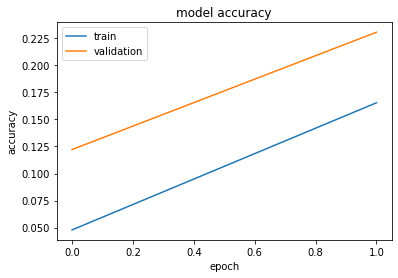

In [25]:
with strategy.scope():
    model = build_model(num_classes=NUM_CLASSES, bilinear=True)

epochs = 2  # @param {type: "slider", min:2, max:80}
model.summary()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, 
                callbacks=[early_stopping], verbose=2)
plot_hist(hist)

In [26]:
_, bilinear_accuracy_train =  model.evaluate(ds_train)
_, bilinear_accuracy_test =  model.evaluate(ds_test)

33/33 [==============================] - 22s 637ms/step - loss: 4.0732 - accuracy: 0.2307


Finally, train a Bilinear top using PCA to project the EfficientNetB0 embeddings into a more semantically enriched subset.

pca_list[0].shape (49, 49)
(None, 7, 7, 1280)
build
projectors MirroredVariable:{
  0: <tf.Variable 'projector1d_2/Variable:0' shape=(1280, 49, 49) dtype=float32, numpy=
array([[[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.]],

       ...,

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0

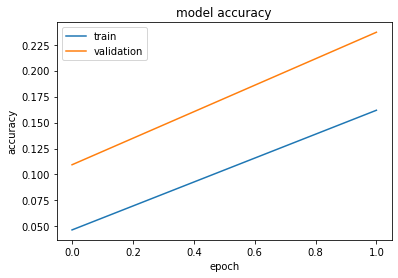

In [27]:
with strategy.scope():
    model = build_model(num_classes=NUM_CLASSES, bilinear=True, pca_list=pca_list)

epochs = 2  # @param {type: "slider", min:2, max:80}
model.summary()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, 
                callbacks=[early_stopping], verbose=2)
plot_hist(hist)

In [28]:
_, pca_accuracy_train =  model.evaluate(ds_train)
_, pca_accuracy_test =  model.evaluate(ds_test)

33/33 [==============================] - 22s 655ms/step - loss: 4.0641 - accuracy: 0.2370


In [29]:
# print('Accuracy for Generic Top, Training/Testing\n\t', generic_accuracy_train, '\n\t', generic_accuracy_test)
print('Accuracy for Bilinear Top, Training/Testing\n\t', bilinear_accuracy_train, '\n\t', bilinear_accuracy_test)
print('Accuracy for Bilinear PCA Top, Training/Testing\n\t', pca_accuracy_train, '\n\t', pca_accuracy_test)

Accuracy for Bilinear Top, Training/Testing
	 0.27547553181648254 
	 0.23070549964904785
Accuracy for Bilinear PCA Top, Training/Testing
	 0.27250340580940247 
	 0.2369791716337204
